## [Don't Overfit](https://www.kaggle.com/c/dont-overfit-ii/leaderboard)

* Bayesioan Optimization  +  NN 을 활용해서 Overfit 방지하면서 돌려보기
* Normalization 추가

* [Weight Regularization Good Article](https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/)

In [1]:
# !pip install bayesian-optimization --user

import pandas as pd , numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from bayes_opt import BayesianOptimization
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from sklearn.metrics import balanced_accuracy_score
from collections import Counter
from MulticoreTSNE import MulticoreTSNE as TSNE
from IPython.display import clear_output
import collections, os
import pickle
from sklearn.preprocessing import normalize


os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
df = pd.read_csv("./Data/dont-overfit-ii/train.csv")
df.shape

test_df = pd.read_csv("./Data/dont-overfit-ii/test.csv")

In [3]:
test_df = test_df.drop("id", axis = 1)

In [4]:
label = df["target"]
Input = df.drop(columns=['id', 'target'])

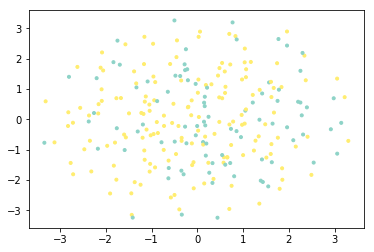

In [5]:
tsne = TSNE(n_jobs=15)
manifold = tsne.fit_transform(Input.values)
plt.scatter(manifold[:,0] , manifold[:,1] , c= label.values , 
            cmap=plt.cm.get_cmap("Set3", 2), marker='.')
plt.show()

In [6]:
test_df = test_df.values.astype(np.float32)
x_data = Input.values.astype(np.float32)

x_data = normalize(x_data)
test_df = normalize(test_df)

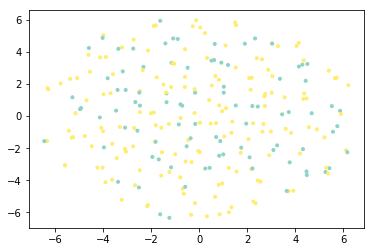

In [7]:
tsne = TSNE(n_jobs=15)
manifold = tsne.fit_transform(x_data)
plt.scatter(manifold[:,0] , manifold[:,1] , c= label.values , 
            cmap=plt.cm.get_cmap("Set3", 2), marker='.')
plt.show()

In [8]:



y_datalabel = label
y_data = LabelEncoder().fit_transform(label)

onehot = np.zeros((y_data.shape[0], np.unique(y_data).shape[0]))
for i in range(y_data.shape[0]):
    onehot[i, y_data[i]] = 1.0
x_train, x_test, y_train, y_test, y_train_label, y_test_label = train_test_split(x_data, onehot, y_data, test_size = 0.3)

In [9]:
print(x_train.shape)
print(sorted(Counter(y_train_label).items()))

(175, 300)
[(0, 61), (1, 114)]


In [10]:
def focal_loss_sigmoid(labels,logits,alpha=0.25 , gamma=2):
    y_pred=tf.nn.sigmoid(logits)
    labels=tf.to_float(labels)
    L=-labels*(1-alpha)*((1-y_pred)*gamma)*tf.log(  tf.maximum(y_pred , 1e-14 )   )-\
      (1-labels)*alpha*(y_pred**gamma)*tf.log( tf.maximum( 1-y_pred ,  1e-14 ) ) 
    return L

def spectral_norm(w, iteration= 2 , name = None):
    w_shape = w.shape.as_list()
    w = tf.reshape(w, [-1, w_shape[-1]])
    
    u = tf.get_variable(name , [1, w_shape[-1]], initializer=tf.random_normal_initializer(), trainable=False)

    u_hat = u
    v_hat = None
    for i in range(iteration):
       
        """
       power iteration
       Usually iteration = 1 will be enough
       """
        
        v_ = tf.matmul(u_hat, tf.transpose(w))
        v_hat = tf.nn.l2_normalize(v_)

        u_ = tf.matmul(v_hat, w)
        u_hat = tf.nn.l2_normalize(u_)

    u_hat = tf.stop_gradient(u_hat)
    v_hat = tf.stop_gradient(v_hat)

    sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))

    with tf.control_dependencies([u.assign(u_hat)]):
        w_norm = w / sigma
        w_norm = tf.reshape(w_norm, w_shape)

    return w_norm 


In [11]:
l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)

def neural_network(num_hidden, size_layer, learning_rate , dropout_rate , beta ,
                   activation , focal_weight , reduction_node , l1_scale , l2_scale, batch_size = 20 ,
                   x_train = x_train , y_train = y_train  ):
    
    def activate(activation, first_layer, second_layer, bias):
        if activation == 0:
            activation = tf.nn.leaky_relu
#         elif activation == 1:
#             activation = tf.nn.tanh
        elif activation == 1:
            activation = tf.nn.relu
        elif activation == 2:
            activation = tf.nn.elu
        elif activation == 3:
            activation = tf.nn.relu6
        else :
            activation = tf.nn.selu
            
        layer = activation(tf.matmul(first_layer, second_layer) + bias)
        return tf.contrib.nn.alpha_dropout(layer, dropout_rate)

    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, (None, x_data.shape[1]))
    Y = tf.placeholder(tf.float32, (None, onehot.shape[1]))
    ## W = tf.Variable(tf.contrib.layers.xavier_initializer()((n_prev, n)))
    
    
    
    input_layer = tf.Variable(tf.contrib.layers.xavier_initializer()((x_data.shape[1], size_layer)))
    biased_layer = tf.Variable(tf.random_normal([size_layer], stddev = 0.1))
    output_layer = tf.Variable(tf.contrib.layers.xavier_initializer()((size_layer - reduction_node * (num_hidden - 1), onehot.shape[1])))
    #biased_output = tf.Variable(tf.random_normal([onehot.shape[1]], stddev = 0.1))
    
    
    layers, biased = [], []
    
#     for i in range(num_hidden - 1):
#         layers.append(tf.Variable(tf.contrib.layers.xavier_initializer()((size_layer, size_layer))))
#         biased.append(tf.Variable(tf.random_normal([size_layer])))
     
    for i in range(num_hidden - 1):
        size_layer2 = size_layer - reduction_node 
        layers.append( spectral_norm(tf.Variable(tf.contrib.layers.xavier_initializer()((size_layer, size_layer2))) , name = "SN" + str(i)) )        
        biased.append(tf.Variable(tf.random_normal([size_layer2])))
        size_layer = size_layer2
    
    
    
    first_l = activate(activation, X, input_layer, biased_layer)
    next_l = activate(activation, first_l, layers[0], biased[0])
    
    for i in range(1, num_hidden - 1):
        next_l = activate(activation, next_l, layers[i], biased[i])
    
    last_l = tf.matmul(next_l, output_layer) # + biased_output
    cost2 = tf.reduce_sum( focal_loss_sigmoid(logits = last_l, labels = Y , alpha = focal_weight ))
    beta_Factor = 0.99
    cost2 = (1- beta_Factor) / (1- beta_Factor**batch_size) * cost2
    # tf.nn.softmax_cross_entropy_with_logits_v2(logits = last_l, labels = Y)
      
    #regularizers = tf.nn.l2_loss(input_layer) +  sum(map(lambda x: tf.nn.l2_loss(x), layers)) + tf.nn.l2_loss(output_layer)
    #+ 
    regularizers = tf.contrib.layers.l1_l2_regularizer(l1_scale , l2_scale)(input_layer) + \
    sum(map(lambda x: tf.contrib.layers.l1_l2_regularizer(l1_scale , l2_scale)(x), layers))  \
    + tf.contrib.layers.l1_l2_regularizer(l1_scale, l2_scale)(output_layer)
    
    #tf.contrib.layers.l1_l2_regularizer(1.0, 1.0)(input_layer) + 
    # tf.contrib.layers.l1_regularizer
    
    cost = cost2 + beta * regularizers
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    last_l = tf.nn.sigmoid(last_l)
    last_l = tf.argmax( last_l, 1)
    last_y = tf.argmax(Y, 1)
    #correct_prediction = tf.equal(, )
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    #sess = tf.InteractiveSession()
    #sess.run(tf.global_variables_initializer())
    
    config=tf.ConfigProto( log_device_placement=True)
    config.gpu_options.allow_growth = True
    sess = tf.Session(config = config)
    sess.run(tf.global_variables_initializer())
    
    
    COST, TEST_COST, ACC, TEST_ACC = [], [], [], []
    
    for i in range(5000):
        train_acc, train_loss = 0, 0
        train_dt = np.concatenate((x_train , y_train) , axis = 1)
        np.random.shuffle(train_dt)
        x_train = train_dt[:,:-2]
        y_train = train_dt[:,-2:]
        for n in range(0, (x_train.shape[0] // batch_size) * batch_size, batch_size):
            _, loss , loss2 , regu2 = sess.run([optimizer, cost , cost2 , regularizers ], 
                                                 feed_dict = {X: x_train[n: n + batch_size, :], Y: y_train[n: n + batch_size, :]})
            TRUE , PRED = sess.run([last_l , last_y], feed_dict = {X: x_train[n: n + batch_size, :], Y: y_train[n: n + batch_size, :]})
            train_acc += balanced_accuracy_score(TRUE , PRED)
            train_loss += loss
            
        
        if i % 1000 == 0 :
            print("Epoch : {} , Train Loss : {} , Regularizer : {} , Total Loss : {} ".format(i ,loss2 , regu2 , loss))

        
        train_loss /= (x_train.shape[0] // batch_size)
        train_acc /= (x_train.shape[0] // batch_size)
        ACC.append(train_acc)
        COST.append(train_loss)
    ## test는 학습 다하고 딱 한번만 하는 것이 맞지 않을까? 
    
    TEST_COST.append(sess.run(cost, feed_dict = {X: x_test, Y: y_test}))
    TRUE , PRED = sess.run([last_l , last_y], feed_dict = {X: x_test, Y: y_test})
    TEST_ACC.append(balanced_accuracy_score(TRUE , PRED))

    clear_output(wait=True)
    COST = np.array(COST).mean()
    ACC = np.array(ACC).mean()
    
    TEST_COST = np.array(TEST_COST).mean()
    TEST_ACC = np.array(TEST_ACC).mean()
    
    Test_TRUE = sess.run([last_l], feed_dict = { X: test_df })
    test_pred_n = collections.Counter(Test_TRUE[0])
    
    if TEST_ACC > 0.71 : 
        TEST_ACC = np.round(TEST_ACC , 3)
        with open('test_v2_predict_{}.pkl'.format(TEST_ACC), 'wb') as f:
            pickle.dump(Test_TRUE, f)
    
    return COST, TEST_COST, ACC, TEST_ACC , test_pred_n

In [15]:
def generate_nn(num_hidden, size_layer, learning_rate, dropout_rate, beta, activation , focal_weight , reduction_node , l1_scale , l2_scale):
    global accbest
    param = {
        'num_hidden' : int(np.around(num_hidden)),
        'size_layer' : int(np.around(size_layer)),
        'learning_rate' : max(min(learning_rate, 1), 0.0001),
        'dropout_rate' : max(min(dropout_rate, 0.7), 0.2),
        'beta' : max(min(beta, 0.5), 0.000001),
        'activation': int(np.around(activation)) , 
        "focal_weight" : max( min(focal_weight , 0.5) , 0.01) ,
        "reduction_node" : min( int(reduction_node) , int(np.around(size_layer) / np.around(num_hidden) )- 10  ) ,
        "l1_scale" : max( l1_scale , 0.0001), 
        "l2_scale" : max( l2_scale , 0.0001)
    }
    print("\n Search parameters \n %s" % (param), file = log_file)
    
    log_file.flush()
    learning_cost, valid_cost, learning_acc, valid_acc , test_pred_n = neural_network(**param)
    print("stop after 5000 iteration with train cost %f, test cost %f, train acc %f, test acc %f" % (learning_cost, valid_cost, learning_acc, valid_acc))
    
    f = open("nn-bayesian_acc_v2.txt",'a')
    result_ = "stop after 5000 iteration with train cost {:.3f}, test cost {:.3f}, train acc {:.3f}, test acc {:.3f} , True Test: {} \n".format(learning_cost, valid_cost, learning_acc, valid_acc , test_pred_n)
    f.write(result_)
    if (valid_acc > accbest):
        costbest = valid_acc
    return valid_acc

In [ ]:
log_file = open('nn-bayesian_v2.log', 'a')
accbest = 0.75
NN_BAYESIAN = BayesianOptimization(generate_nn, 
                              {'num_hidden': (4, 8),
                               'size_layer': (df.shape[1]-30 , df.shape[1] + 10 ),
                               'learning_rate': (0.001, 0.0001),
                               'dropout_rate': (0.2, 0.7),
                               'beta': (0.01, 0.001),
                               'activation': (0, 4),
                               "focal_weight" : (0.2 , 0.6),
                               "reduction_node" : (30 , 70 ) ,
                               "l1_scale" : (0 , 0.1) ,
                               "l2_scale" : (0 , 0.1) ,
                              })
NN_BAYESIAN.maximize(init_points = 100 , n_iter = 1000 , acq="ucb", kappa= 10.0)

stop after 5000 iteration with train cost 0.412983, test cost 1.484423, train acc 0.646703, test acc 0.613333
|  23       |  0.6133   |  3.513    |  0.004437 |  0.4453   |  0.5347   |  0.09851  |  0.0824   |  0.000741 |  5.022    |  34.11    |  277.4    |
Epoch : 0 , Train Loss : 1.0526440143585205 , Regularizer : 103.47221374511719 , Total Loss : 1.4994051456451416 
Epoch : 1000 , Train Loss : 0.26822784543037415 , Regularizer : 2.5952842235565186 , Total Loss : 0.2794334888458252 
Epoch : 2000 , Train Loss : 0.33184918761253357 , Regularizer : 1.100816011428833 , Total Loss : 0.33660218119621277 
